In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [18]:
# Load Google stock prices CSV
df = pd.read_csv('goog.csv')  # Ensure you have 'GOOG.csv' in your folder

# Show first few rows to understand structure
df.head()



,Date,Open,High,Low,Close,Volume
0,05/02/2025,164.96,166.70,163.66,165.81,"16,844,939"
1,05/01/2025,162.52,163.94,160.93,162.79,"21,904,289"
2,04/30/2025,159.86,161.37,157.16,160.89,"20,639,520"
3,04/29/2025,162.05,162.68,159.39,162.06,"15,955,220"
4,04/28/2025,164.26,164.95,160.38,162.42,"20,871,150"


In [19]:
df.shape

(251, 6)

In [20]:

# We'll use the 'Close' price for prediction
closing_prices = df['Close'].values.reshape(-1, 1)

# Normalize prices to range [0, 1] for better training
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(closing_prices)

# Define function to convert price data into sequences for RNN input
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])  # next value to predict
    return np.array(X), np.array(y)

# Sequence length: how many previous days to use for prediction
sequence_length = 60
X, y = create_sequences(scaled_prices, sequence_length)

# Convert numpy arrays to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Reshape input to [samples, time steps, features]
# We only have 1 feature per time step (the price)
X = X.view(X.shape[0], X.shape[1], 1)

# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [21]:
# A simple RNN-based regressor for time series forecasting
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)         # RNN output (out): [batch_size, seq_len, hidden_size]
        last_time_step = out[:, -1]  # Get output from last time step
        out = self.fc(last_time_step)  # Fully connected layer for final prediction
        return out


In [22]:
# Initialize model, loss function and optimizer
model = RNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")


Epoch [50/500], Loss: 0.005729
Epoch [100/500], Loss: 0.004630
Epoch [150/500], Loss: 0.003994
Epoch [200/500], Loss: 0.003511
Epoch [250/500], Loss: 0.003193
Epoch [300/500], Loss: 0.002980
Epoch [350/500], Loss: 0.002836
Epoch [400/500], Loss: 0.002750
Epoch [450/500], Loss: 0.002708
Epoch [500/500], Loss: 0.002689


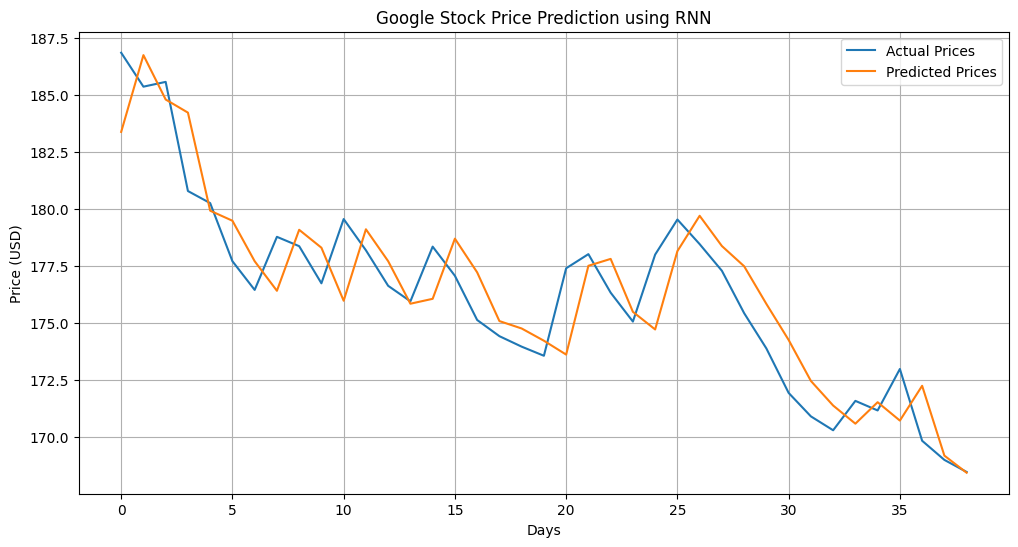

In [24]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).detach().numpy()

# Inverse transform predictions to original scale
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.numpy())

# Plotting predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title("Google Stock Price Prediction using RNN")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute regression metrics
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"\n📈 Evaluation Metrics:")
print(f"🔹 MSE  = {mse:.4f}")
print(f"🔹 RMSE = {rmse:.4f}")
print(f"🔹 MAE  = {mae:.4f}")
print(f"🔹 R² Score = {r2:.4f}")



📈 Evaluation Metrics:
🔹 MSE  = 3.3367
🔹 RMSE = 1.8267
🔹 MAE  = 1.5222
🔹 R² Score = 0.8135
